<a href="https://colab.research.google.com/github/elianezanlorense/Data-Mining-2/blob/master/Transfer_Services_Demand_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Packages loading

In [9]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Import packages
import csv
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import re
from sklearn.metrics import accuracy_score, auc, classification_report, confusion_matrix, roc_curve
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample

In [0]:
# Summary statistics for all variables
def summary(dataframe):
    summary=dataframe.describe(include='all') 
    summary=summary.transpose()
    return summary.head(len(summary))

## Customers

In [11]:
# Load and show dataset info 
df_customers = pd.DataFrame(pd.read_csv("/content/drive/My Drive/Business/06 - Case Services Demand Forecasting-20200501/YFT_Customers.csv", sep=";"))
df_customers

,customerID,countryID,subscribeNewsletter,loyaltyCard,services,active
0,0,44,0,0,0,1
1,1,44,0,33,3,1
2,3,44,0,1,0,1
3,4,44,0,1,0,1
4,5,44,0,1,0,1
...,...,...,...,...,...,...
163878,219062,44,0,0,0,1
163879,219063,44,0,0,0,1
163880,219064,44,1,0,0,1
163881,219065,43,0,0,0,1


In [0]:
df_customers=df_customers.rename(columns={"id": "customerID"})
df_customers=df_customers.rename(columns={"pais_id": "countryID"})
df_customers=df_customers.rename(columns={"newsletter": "subscribeNewsletter"})
df_customers=df_customers.rename(columns={"loyaltycard": "loyaltyCard"})
df_customers=df_customers.rename(columns={"viagens": "services"})
df_customers=df_customers.rename(columns={"activo": "active"})


### Dataset description

- **customerID**: customer ID
- **countryID**: in the format of the international phone dialing code
- **subscribeNewsletter**: indication if customer subscribed to YFT newsletter (0:No, 1:Yes)
- **loyaltyCard**:  points accumulated on loyalty card
- **services**:   total services provided to the customer so far
- **active**: indication if customer is still active (0:No, 1:Yes)

### Data Understanding

In [13]:
# Summary statistics for all variables
summary(df_customers)

,count,mean,std,min,25%,50%,75%,max
customerID,163883.0,118328.097991,68439.491583,0.0,53902.0,135931.0,177917.5,219066.0
countryID,163883.0,366.848673,1524.554186,0.0,44.0,44.0,353.0,9999.0
subscribeNewsletter,163883.0,0.129556,0.335815,0.0,0.0,0.0,0.0,1.0
loyaltyCard,163883.0,2.356602,5.008985,-14.0,0.0,2.0,2.0,241.0
services,163883.0,0.057480,0.440035,-2.0,0.0,0.0,0.0,24.0
active,163883.0,0.999750,0.016196,-1.0,1.0,1.0,1.0,1.0


In [14]:
# Check missing values
print(df_customers.isnull().sum())

customerID             0
countryID              0
subscribeNewsletter    0
loyaltyCard            0
services               0
active                 0
dtype: int64


In [16]:
df_customers.customerID.unique()

array([     0,      1,      3, ..., 219064, 219065, 219066])

In [17]:
df_customers.countryID.unique()

array([  44,  353,   31,   49,    1,  351,   47,   33,   46,   32, 9999,
        352,   45,  852,   55,  372,   34,  370,  385,   61,    7,  371,
         40,   41,  972,  358,   48,   43,   36,  381,  971,   39,  421,
        681,  420,   82,  216,  995,   27,   64,  354,  375,  966,  973,
        599,  255,  268,   81,   65,  386,    4,   86,  357,  965,   20,
         66,  961,    0,   91,  359,  962,  389,  356,  886,  380,  974,
        853,  229,   52,  968,   62,   56,  213,  678,   30,   90,  374,
        700,  256,  376,  212,   60,  977,  423,   54,   51,  505,   93,
        233,   84,   63,   57,  502,  262,   58,   95,  598,  237,  258,
        350,  265,  238,  297,  243,  263,  506,  689,  299])

In [18]:
df_customers.subscribeNewsletter.unique()

array([0, 1])

In [19]:
df_customers.loyaltyCard.unique()

array([  0,  33,   1,   2,   6,   8, 154,   4,  38,  50,  43, 111,  13,
        10,  26,  29,   3,  66,  37,  28,   5,   7,  20,  30,  12,  18,
        25,  19,  24,   9,  14, 127,  -1,  64,  46,  87,  22,  40,  17,
        21,  32,  42,  11,  54, 104,  31,  36,  39,  16,  60,  77,  82,
        52,  34,  84,  71,  23,  45, 101,  59, 172,  61,  78,  15, 110,
        70,  72,  -2,  27, 131,  62,  35,  49,  86, 123,  44,  47,  65,
        69, 173,  56,  58,  85,  88,  41,  63,  81, 161,  48, 112,  94,
       124,  80,  55,  57, 158, 132,  67,  51,  98, 179,  97, 139,  76,
       152, 119,  -3, 100,  74, 146,  93,  89,  92, 126,  90, 241, 120,
        68,  -4, 107, 137, 121,  53, 135, 105, 192, 174, 129, 134, 150,
        91,  73, 109,  75,  -8, -14,  -5,  79, 113, -12,  -7,  -6, -10])

In [20]:
df_customers.services.unique()

array([ 0,  3, 15,  5,  1,  4, 11,  2,  6, 12,  8, 10,  7,  9, 17, 13, 14,
       24, 19, -2])

In [21]:
df_customers.active.unique()

array([ 1,  0, -1])

### Data Preprocessing

In [0]:
# Get names of indexes for which column Age has value 30
indexNames = df_customers[ df_customers['loyaltyCard'] < 0 ].index
# Delete these row indexes from dataFrame
df_customers.drop(indexNames , inplace=True)

In [0]:
# Get names of indexes for which column Age has value 30
indexNames = df_customers[ df_customers['services'] < 0 ].index
# Delete these row indexes from dataFrame
df_customers.drop(indexNames , inplace=True)

In [0]:
# Get names of indexes for which column Age has value 30
indexNames = df_customers[ df_customers['active'] == -1 ].index
# Delete these row indexes from dataFrame
df_customers.drop(indexNames , inplace=True)

In [0]:
#Replace Undefined for just UN and delete the record without 
#people assigned to them(errors)
no_activity = list(df_customers.loc[df_customers["services"]
                   + df_customers["active"]
                   + df_customers["loyaltyCard"]==0].index)
df_customers.drop(df_customers.index[no_activity], inplace=True)


In [26]:
duplicates = df_customers.loc[df_customers['customerID'].duplicated(False),:]
duplicates.head()
duplicates.shape

(0, 6)

In [27]:
df_customers=df_customers.sort_values('customerID')
df_customers=df_customers.set_index('customerID')
df_customers

,countryID,subscribeNewsletter,loyaltyCard,services,active
customerID,,,,,
0,44,0,0,0,1
1,44,0,33,3,1
3,44,0,1,0,1
4,44,0,1,0,1
5,44,0,1,0,1
...,...,...,...,...,...
219062,44,0,0,0,1
219063,44,0,0,0,1
219064,44,1,0,0,1


### Merge with datasets relating country to countryID

In [0]:
# Load and show dataset info 
df_c = pd.DataFrame(pd.read_csv("data.csv", sep=","))
df_c

In [0]:
df_c=df_c.drop(['Official_Name_English', 'ISO3166_1_Alpha_2', 'ISO3166_1_Alpha_3', 'ISO4217_Currency_Minor_Unit', 'ISO4217_Currency_Name', 'Is_Independent', 'Capital', 'Continent', 'TLD', 'Languages','Geo_Name_ID','EDGAR','ISO4217_Currency_Alphabetic_Code', 'ISO4217_Currency_Country_Name', 'ISO4217_Currency_Country_Name', 'MARC', 'WMO', 'DS', 'FIFA', 'FIPS','IOC','ISO4217_Currency_Numeric_Code', 'ITU', 'GAUL', 'M49'], axis=1)


In [0]:
df_c

In [0]:
df_c= df_c.dropna()


In [0]:
# Check missing values
print(df_c.isnull().sum())

In [0]:
df_c.info()

In [0]:
# Get names of indexes for which column Age has value 30
indexNames = df_c[df_c['Dial'] == 'nan'].index
# Delete these row indexes from dataFrame
df_c.drop(indexNames , inplace=True)

In [0]:
# Get names of indexes for which column Age has value 30
indexNames = df_c[ df_c['Dial'] == '39-06' ].index
# Delete these row indexes from dataFrame
df_c.drop(indexNames , inplace=True)

In [0]:
df_c['Dial'].replace("1-684", '684', inplace=True)
df_c['Dial'].replace("1-264", '264', inplace=True)
df_c['Dial'].replace("1-242", "242", inplace=True)
df_c['Dial'].replace("1-268", "268", inplace=True)
df_c['Dial'].replace("1-441", "441", inplace=True)
df_c['Dial'].replace("1-246", "246", inplace=True)
df_c['Dial'].replace("1-284", "284", inplace=True)
df_c['Dial'].replace("1-345", "345", inplace=True)
df_c['Dial'].replace("1-767", "767", inplace=True)
df_c['Dial'].replace("1-809,1-829,1-849", "829", inplace=True)
df_c['Dial'].replace("1-473", "473", inplace=True)
df_c['Dial'].replace("1-671", "671", inplace=True)
df_c['Dial'].replace("1-876", "876", inplace=True)
df_c['Dial'].replace("1-664", "664", inplace=True)
df_c['Dial'].replace("1-670", "670", inplace=True)
df_c['Dial'].replace("381 p", "381", inplace=True)
df_c['Dial'].replace("1-721", "721", inplace=True)
df_c['Dial'].replace("1-758", "758", inplace=True)
df_c['Dial'].replace("1-869", "869", inplace=True)
df_c['Dial'].replace("290 n", "290", inplace=True)
df_c['Dial'].replace("1-784", "784", inplace=True)
df_c['Dial'].replace("1-868", "868", inplace=True)
df_c['Dial'].replace("1-649", "649", inplace=True)
df_c['Dial'].replace("1-340", "340", inplace=True)


In [0]:
df_c['Dial'].unique()


In [0]:
df_c['Dial'] = df_c['Dial'].astype('int64')


In [0]:
df_customers= pd.merge(df_customers, df_c, left_on='countryID', right_on='Dial')


In [0]:
df_customers=df_customers.drop(columns=['countryID', 'Dial'])


In [0]:
df_customers

In [0]:
df_customers.to_excel("customers.xlsx")  


### Data Exploration 

#### Active vs Inactive Customers

<img src="activeCustomers.JPG" alt="xxx" style="width: 600px;"/>

#### Customer country

<img src="CustomerCountry.JPG" alt="xxx" style="width: 600px;"/>

#### Customer Loyalty card points

<img src="loyaltycard.JPG" alt="xxx" style="width: 600px;"/>

#### Customer newsletter subscribers

<img src="newsletterSubscribers.JPG" alt="xxx" style="width: 600px;"/>

#### Customer services

<img src="services.JPG" alt="xxx" style="width: 600px;"/>

## Locals

In [38]:
# Load and show dataset info 
df_locals = pd.DataFrame(pd.read_csv("/content/drive/My Drive/Business/06 - Case Services Demand Forecasting-20200501/YFT_Locals.csv", sep=";"))
df_locals.head()

,id,local,area
0,1,ALBUFEIRA,albufeira
1,6,ALCANTARILHA,armacao
2,130,ALCOUTIM,alcoutim
3,7,ALGOZ,silves
4,8,ALJEZUR,aljezur


## Drivers

In [29]:
# Load and show dataset info 
df_drivers = pd.DataFrame(pd.read_csv("/content/drive/My Drive/Business/06 - Case Services Demand Forecasting-20200501/YFT_Drivers.csv", sep=";"))
df_drivers.head(2)

,driverID,birthday,localID
0,1,1966-11-03,0
1,2,1957-09-01,32


In [0]:
df_drivers=df_drivers.rename(columns={"id": "driverID"})
df_drivers=df_drivers.rename(columns={"birthday": "BirthDate"})
df_drivers=df_drivers.rename(columns={"locais_id": "localID"})

### Dataset description

- **id**: Unique identifier of the guest
- **birthday**: The gender of the guest
- **locais_id**: Binary variable indicating if the guest is a frequent flier or not

### Data Understanding

In [0]:
summary(df_drivers)

In [33]:
# Check missing values
print(df_drivers.isnull().sum())

driverID     0
BirthDate    0
localID      0
dtype: int64


In [32]:
df_drivers.driverID.unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  95,  97,  99, 101, 103, 105, 107, 109, 111, 113, 115,
       117, 119, 121, 123, 125, 127, 129, 131, 133, 135, 137, 139, 141,
       143, 145, 147, 149, 151, 153, 155, 157, 159, 161, 163, 165, 167,
       169, 171, 173, 175, 177, 179, 181, 183, 185, 187, 189, 191, 193,
       195, 197, 199, 201, 203, 205, 207, 209, 211, 213, 215, 217, 219,
       221, 223, 225, 227, 229, 231, 233, 235, 237, 239, 241, 243, 245,
       247, 249, 251, 253, 255, 257, 259, 261, 263, 265, 267, 26

In [34]:
df_drivers.BirthDate.unique()

array(['1966-11-03', '1957-09-01', '1961-07-10', '1987-03-09',
       '1976-10-16', '1968-02-11', '0000-00-00', '1991-04-22',
       '1975-05-19', '1992-06-23', '1976-12-11', '1970-02-04',
       '1987-10-23', '1985-12-12', '1973-08-11', '1982-01-02',
       '1983-02-03', '1982-11-13', '1979-12-23', '1987-10-08',
       '1979-06-15', '1989-10-09', '1989-06-05', '1992-12-11',
       '1979-02-21', '1971-03-25', '1982-07-04', '1969-01-27',
       '1971-07-08', '1965-09-22', '1967-10-06', '1988-08-10',
       '1986-11-04', '1972-07-04', '1980-01-26', '1990-08-21',
       '1971-12-20', '1951-02-12', '1977-05-19', '1974-12-05',
       '1980-08-28', '1964-05-01', '1988-04-27', '1991-11-13',
       '1975-08-21', '1983-02-24', '1983-07-11', '1971-11-14',
       '1974-08-17', '1992-05-27', '1971-04-19', '1988-03-21',
       '1973-11-18', '1971-09-01', '1972-09-29', '1988-05-10',
       '1984-02-29', '1974-10-31', '1991-02-12', '1982-08-04',
       '1947-12-14', '1968-06-07', '1971-11-16', '1991-

In [35]:
df_drivers.localID.unique()

array([  0,  32,   1,  44, 126,  54,  12,  20,  31,   3, 182,  29,  40,
        50, 122,  22,  85,  21,  11,   2,  68,   6, 133,   9,   7, 148,
        23,  26,  24,  47,  10,  17, 239,  18,  49,  28])

### Data Preprocessing

In [36]:
duplicates = df_drivers.loc[df_drivers['driverID'].duplicated(False),:]
duplicates.head()
duplicates.shape

(0, 3)

### Merging with locals dataset 
Connecting th localID to local

In [0]:
df_drivers= pd.merge(df_drivers, df_locals, left_on='localID', right_on='id')


In [0]:
df_drivers=df_drivers.drop(['localID', 'id', 'area'], axis=1)


In [76]:
df_drivers.head()

,driverID,BirthDate,local
0,2,1957-09-01,PORTIMAO
1,93,1971-11-14,PORTIMAO
2,107,1972-09-29,PORTIMAO
3,119,1947-12-14,PORTIMAO
4,135,1971-07-30,PORTIMAO


In [0]:
df_drivers.to_excel("drivers.xlsx")  


### Data Exploration

#### Drivers' location

<img src="driverLocation.JPG" alt="xxx" style="width: 600px;"/>

## Luggage

In [44]:
# Load and show dataset info 
df_luggage = pd.DataFrame(pd.read_csv("/content/drive/My Drive/Business/06 - Case Services Demand Forecasting-20200501/YFT_Luggage.csv", sep=";"))
df_luggage.head(2)

,book_id,whichway,cargo,qtd,timer
0,71925,arrival,cabin_luggage,2,2015-03-05 11:33:39
1,71925,arrival,checked_luggage,2,2015-03-05 11:33:39


In [0]:
df_luggage=df_luggage.rename(columns={"qtd": "quantity"})
df_luggage=df_luggage.rename(columns={"book_id": "bookingID"})


### Dataset description
    
- **bookingID**: Unique identifier of the guest
- **whichway**: type of service (arrival or departure)
- **cargo**: type of luggage (checked_luggage, cabin_luggage, others)
- **quantity**: quantity of this type of cargo
- **timer**:  date and time when YFT become aware of this luggage information

### Data Understanding

In [46]:
summary(df_luggage)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
bookingID,646400,NaN,NaN,NaN,196310,74626.2,15250,130532,193860,259440,330151
whichway,646400,2,arrival,327052,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cargo,646400,9,cabin_luggage,346562,NaN,NaN,NaN,NaN,NaN,NaN,NaN
quantity,646400,NaN,NaN,NaN,2.56464,1.98867,0,1,2,3,100
timer,646400,230730,2017-01-16 13:20:21,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
# Check missing values
print(df_luggage.isnull().sum())

bookingID    0
whichway     0
cargo        0
quantity     0
timer        0
dtype: int64


In [48]:
df_luggage.bookingID.unique()

array([ 71925,  71926,  71927, ..., 330149, 330150, 330151])

In [0]:
df_luggage.whichway.unique()

In [51]:
df_luggage.cargo.unique()

array(['cabin_luggage', 'checked_luggage', 'child_buggy', 'golf_bags',
       'wheelchair', 'bike_box', 'scooters', 'surf_board', 'pets_crates'],
      dtype=object)

In [50]:
df_luggage.quantity.unique()

array([  2,   0,   3,   1,   4,   5,   7,   6,  10,   8,  16,  11,  24,
        21,   9,  12,  14,  13,  20,  19,  18,  15,  23,  17,  22,  26,
        30,  25,  50, 100,  32,  28,  29,  31,  36,  56,  27,  39,  35,
        33,  34,  37,  38])

In [52]:
df_luggage.timer.unique()

array(['2015-03-05 11:33:39', '2015-03-05 11:38:14',
       '2015-03-05 11:41:07', ..., '2019-12-02 10:36:44',
       '2019-12-02 10:39:22', '2019-12-02 10:46:22'], dtype=object)

In [56]:
df_luggage=df_luggage.sort_values('bookingID')
df_luggage=df_luggage.set_index('bookingID')
df_luggage.head()

KeyError: ignored

In [54]:
df_luggage.to_excel("luggage.xlsx")  


KeyboardInterrupt: ignored

### Data Exploration

<img src="reasonForCancellarion.JPG" alt="xxx" style="width: 600px;"/>

<img src="way.JPG" alt="xxx" style="width: 600px;"/>

## Feedback

In [57]:
# Load andate and time when YFT become aware of this luggage information
df_feedback = pd.DataFrame(pd.read_csv("/content/drive/My Drive/Business/06 - Case Services Demand Forecasting-20200501/YFT_Feedback.csv", sep=";"))
df_feedback.head()

,id,book_id,codigo,welcome_arrival,welcome_departure,punctual_arrival,clean_in_arrival,clean_out_arrival,clean_in_departure,clean_out_departure,freegift,punctual_departure,driving_arrival,driving_departure,curteous_arrival,curteous_departure,website,experience,quality,comments,timer
0,1,4319,RAL,5,0,5,5,5,0,0,5,5,5,5,5,4,3,5,0,NaN,NaN
1,2,4256,RAL,5,0,5,5,5,0,0,5,5,5,5,5,5,5,5,0,NaN,NaN
2,3,2758,RAL,5,0,5,5,5,0,0,5,5,5,5,5,5,5,5,0,NaN,NaN
3,4,4095,RAL,4,0,5,5,5,0,0,5,5,5,5,5,4,4,5,0,Great Service. Would use again.,NaN
4,5,3796,RAL,5,0,5,4,3,0,0,5,5,4,4,5,4,3,4,0,Please note I book on behalf of people visitin...,NaN


In [0]:
df_feedback=df_feedback.rename(columns={"id": "feedbackID"})
df_feedback=df_feedback.rename(columns={"book_id": "bookingID"})
df_feedback=df_feedback.rename(columns={"codigo": "typeOfService"})


### Dataset description

- **feedbackID**: feedback ID
- **bookingID**: booking ID
- **typeOfService**:  code for type of service. Could be "GOF" for "golf round trip" or 3 letters that mean: 
1st letter: type of service purchase (O:One way, R:Return)
2nd letter: Origin (A:Airport, L:Location)
3rd letter: Destination (A:Airport, L:Location)
- **welcome_arrival**: rating on how customer was welcomed at arrival
- **welcome_departure**:  rating on how customer was welcomed at departure
- **punctual_arrival**: rating on service punctuality at arrival
- **clean_in_arrival**: rating on vehicle cleaning at arrival
- **clean_out_arrival**: rating on vehicle cleaning and check for lost items at
the end of the arrival service
- **clean_in_departure**: rating on vehicle cleaning at departure
- **clean_out_departure**:  rating on vehicle cleaning and check for lost items
at the end of the departure service
- **free_gift**: rating on free amenities offered
- **punctual_departure**: rating on service punctuality at departure
- **driving_arrival**: rating on driving quality at arrival
- **driving_departure**: rating on driving quality at departure
- **curteous_arrival**: rating on driver courteousness at arrival
- **curteous_departure**: rating on driver courteousness at departure
- **website**: rating of YFT website quality
- **experience**: rating on the overall experience
- **quality**: rating on the overall quality
- **comments**:  customers own words on the service experience
- **timer**: date and time of when the feedback given 


### Data Understanding

In [59]:
summary(df_feedback)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
feedbackID,82724,NaN,NaN,NaN,61861.9,33741.2,1,32444.5,69826.5,90509.2,111191
bookingID,82724,NaN,NaN,NaN,170777,93810.4,130,91396.8,165716,255838,330075
typeOfService,82724,4,RAL,65681,NaN,NaN,NaN,NaN,NaN,NaN,NaN
welcome_arrival,82724,NaN,NaN,NaN,4.52904,1.31093,0,5,5,5,5
welcome_departure,82724,NaN,NaN,NaN,1.53422,2.28492,0,0,0,5,5
punctual_arrival,82724,NaN,NaN,NaN,4.33596,1.62849,0,5,5,5,5
clean_in_arrival,82724,NaN,NaN,NaN,4.61461,1.1821,0,5,5,5,5
clean_out_arrival,82724,NaN,NaN,NaN,4.6072,1.18441,0,5,5,5,5
clean_in_departure,82724,NaN,NaN,NaN,1.56685,2.30523,0,0,0,5,5
clean_out_departure,82724,NaN,NaN,NaN,1.56695,2.30517,0,0,0,5,5


In [0]:
# Check missing values
print(df_feedback.isnull().sum())

In [61]:
df_feedback.feedbackID.unique()

array([     1,      2,      3, ..., 111189, 111190, 111191])

In [62]:
df_feedback.bookingID.unique()

array([  4319,   4256,   2758, ..., 287026, 329632, 330056])

In [63]:
df_feedback.typeOfService.unique()

array(['RAL', 'OLA', 'OAL', 'OLL'], dtype=object)

In [0]:
df_feedback.welcome_arrival.unique()

In [66]:
df_feedback.welcome_departure.unique()

array([0, 5, 4, 2, 3, 1])

In [65]:
df_feedback.punctual_arrival.unique()

array([5, 4, 3, 0, 1, 2])

In [0]:
df_feedback.clean_in_arrival.unique()

In [0]:
df_feedback.clean_out_arrival.unique()

In [68]:
df_feedback.clean_in_departure.unique()

array([0, 4, 5, 2, 3, 1])

In [0]:
df_feedback.clean_out_departure.unique()

In [0]:
df_feedback.freegift.unique()

In [0]:
df_feedback.punctual_departure.unique()

In [0]:
df_feedback.driving_arrival.unique()

In [0]:
df_feedback.driving_departure.unique()

In [0]:
df_feedback.curteous_arrival.unique()

In [0]:
df_feedback.curteous_departure.unique()

In [0]:
df_feedback.curteous_departure.unique()

In [0]:
df_feedback.website.unique()

In [0]:
df_feedback.experience.unique()

In [0]:
df_feedback.quality.unique()

In [0]:
df_feedback.comments.unique()

In [71]:
df_feedback.timer.unique()

array([nan, '2018-03-12 12:27:04', '2018-03-12 13:50:35', ...,
       '2019-12-02 08:54:01', '2019-12-02 09:20:11',
       '2019-12-02 10:05:41'], dtype=object)

In [72]:
df_feedback=df_feedback.sort_values('feedbackID')
df_feedback=df_feedback.set_index('feedbackID')
df_feedback.head()

KeyError: ignored

In [0]:
df_feedback.to_excel("feedback.xlsx")  


### Data Exploration

#### Clean in arrival feedback

<img src="cleanInArrival.JPG" alt="xxx" style="width: 600px;"/>

#### Clean in departure feedback

<img src="cleanInDeparture.JPG" alt="xxx" style="width: 600px;"/>

#### Clean out arrival feedback

<img src="cleanOutArrival.JPG" alt="xxx" style="width: 600px;"/>

#### Clean out departure feedback

<img src="cleanOutDeparture.JPG" alt="xxx" style="width: 600px;"/>

#### Comments

<img src="comments.JPG" alt="xxx" style="width: 600px;"/>

#### Curteous arrival feedback

<img src="curteousArrival.JPG" alt="xxx" style="width: 600px;"/>

#### Curteous departure feedback

<img src="curteousDeparture.JPG" alt="xxx" style="width: 600px;"/>

#### Driving arrival feedback

<img src="drivingArrival.JPG" alt="xxx" style="width: 600px;"/>

#### Driving departure feedback

<img src="drivingDeparture.JPG" alt="xxx" style="width: 600px;"/>

#### Experience feedback

<img src="experience.JPG" alt="xxx" style="width: 600px;"/>

#### Freegift

<img src="freegift.JPG" alt="xxx" style="width: 600px;"/>

#### Punctual arrival feedback

<img src="punctualArrival.JPG" alt="xxx" style="width: 600px;"/>

#### Punctual departure feedback

<img src="punctualDeparture.JPG" alt="xxx" style="width: 600px;"/>

#### Quality feedback

<img src="quality.JPG" alt="xxx" style="width: 600px;"/>

#### Type of service feedback

<img src="typeOfService.JPG" alt="xxx" style="width: 600px;"/>

#### Website feedback

<img src="website.JPG" alt="xxx" style="width: 600px;"/>

#### Welcome arrival feedback

<img src="welcomeArrival.JPG" alt="xxx" style="width: 600px;"/>

#### Welcome departure feedback

<img src="welcomeDeparture.JPG" alt="xxx" style="width: 600px;"/>

## Canceled bookings

In [74]:
# Load and show dataset info 
df_canceledBookings = pd.DataFrame(pd.read_csv("/content/drive/My Drive/Business/06 - Case Services Demand Forecasting-20200501/YFT_CanceledBookings.csv", sep=";"))
df_canceledBookings.head()

,id,bookingID,whichway,reason,timer
0,1,41445,booking,testes,2013-12-02 15:23:02
1,2,41446,booking,Test,2013-12-02 17:50:02
2,3,41446,booking,test,2013-12-02 17:54:49
3,4,41597,booking,cancel by email,2013-12-11 11:43:53
4,5,41718,booking,ESTA XXXX É NOVA...AONDA NA TOU HABITAUDO..OK????,2013-12-18 12:58:59


### Data Understanding

In [75]:
summary(df_canceledBookings)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,11287,NaN,NaN,NaN,8843.66,4375.45,1,5356,9661,12482.5,15304
bookingID,11287,NaN,NaN,NaN,197895,96894,22137,106033,201257,289306,336264
whichway,11287,3,booking,10372,NaN,NaN,NaN,NaN,NaN,NaN,NaN
reason,11281,4414,dup,1319,NaN,NaN,NaN,NaN,NaN,NaN,NaN
timer,11287,11233,2020-03-19 10:50:56,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
# Check missing values
print(df_canceledBookings.isnull().sum())

In [0]:
df_canceledBookings.id.unique()

In [0]:
df_canceledBookings.bookingID.unique()

In [0]:
df_canceledBookings.whichway.unique()

In [0]:
df_canceledBookings.reason.unique()

In [0]:
df_canceledBookings.timer.unique()

In [0]:
df_canceledBookings.to_excel("canceledBookings.xlsx")  


### Data Exploration

#### Reason for boooking canceled

<img src="reasonForCancellarion.JPG" alt="xxx" style="width: 600px;"/>

#### Type of canceled booking

<img src="way.JPG" alt="xxx" style="width: 600px;"/>

## Transfer Bookings

In [77]:
# Load and show dataset info 
df_transferBookings = pd.DataFrame(pd.read_csv("/content/drive/My Drive/Business/06 - Case Services Demand Forecasting-20200501/YFT_TransferBookings.csv", sep=";"))
df_transferBookings

FileNotFoundError: ignored

### Data Understanding

In [0]:
summary(df_transferBookings)

In [0]:
print(df_transferBookings.isnull().sum())

In [0]:
df_transferBookings.info()

In [0]:
df_transferBookings=df_transferBookings.drop(['Unnamed: 24', 'Unnamed: 25', 'Unnamed: 26','Unnamed: 27', 'Unnamed: 28'], axis=1)


In [0]:
df_transferBookings.bookingID.unique()

In [0]:
df_transferBookings.operatorID.unique()

In [0]:
df_transferBookings.whichway.unique()

In [0]:
df_transferBookings.flightNr.unique()

In [0]:
df_transferBookings.paymentType.unique()

In [0]:
df_transferBookings.typeOfService.unique()

In [0]:
df_transferBookings.pickupLocal.unique()

In [0]:
df_transferBookings.dropoffLocal.unique()

In [0]:
df_transferBookings.adults                        .unique()

In [0]:
df_transferBookings.children.unique()

In [0]:
df_transferBookings.babies.unique()

In [0]:
df_transferBookings.bookingStatus                 .unique()

In [0]:
df_transferBookings.serviceStatus                 .unique()

### Data Preprocessing

In [0]:
# Get names of indexes for which column Age has value 30
indexNames = df_transferBookings[ df_transferBookings['bookingStatus'] == 0 ].index
# Delete these row indexes from dataFrame
df_transferBookings.drop(indexNames , inplace=True)

In [0]:
# Get names of indexes for which column Age has value 30
indexNames = df_transferBookings[ df_transferBookings['children'] < 0 ].index
# Delete these row indexes from dataFrame
df_transferBookings.drop(indexNames , inplace=True)

In [0]:
# Get names of indexes for which column Age has value 30
indexNames = df_transferBookings[ df_transferBookings['adults'] == '37.017596,-7.96972' ].index
# Delete these row indexes from dataFrame
df_transferBookings.drop(indexNames , inplace=True)

In [0]:
# Get names of indexes for which column Age has value 30
indexNames = df_transferBookings[ df_transferBookings['adults'] == '37.0970061,-8.2241438'].index
# Delete these row indexes from dataFrame
df_transferBookings.drop(indexNames , inplace=True)

In [0]:
df_transferBookings['adults'] = df_transferBookings['adults'].astype('int64')


In [0]:
# Get names of indexes for which column Age has value 30
indexNames = df_transferBookings[ df_transferBookings['adults'] < 0 ].index
# Delete these row indexes from dataFrame
df_transferBookings.drop(indexNames , inplace=True)

In [0]:
df_transferBookings = df_transferBookings[~df_transferBookings['pickupLocal'].isin(['0'])]


In [0]:
# Get names of indexes for which column Age has value 30
indexNames = df_transferBookings[ df_transferBookings['paymentType'] == '0'].index
# Delete these row indexes from dataFrame
df_transferBookings.drop(indexNames , inplace=True)

In [0]:
# Get names of indexes for which column Age has value 30
indexNames = df_transferBookings[ df_transferBookings['paymentType'] == '2'].index
# Delete these row indexes from dataFrame
df_transferBookings.drop(indexNames , inplace=True)

In [0]:
# Get names of indexes for which column Age has value 30
indexNames = df_transferBookings[ df_transferBookings['paymentType'] == '4'].index
# Delete these row indexes from dataFrame
df_transferBookings.drop(indexNames , inplace=True)

In [0]:
# Get names of indexes for which column Age has value 30
indexNames = df_transferBookings[ df_transferBookings['paymentType'] == 'nan'].index
# Delete these row indexes from dataFrame
df_transferBookings.drop(indexNames , inplace=True)

In [0]:
df_transferBookings['whichway'].replace("departurex", 'departure', inplace=True)


In [0]:
df_transferBookings = df_transferBookings.dropna(subset=['typeOfService', 'pickupLocal', 'dropoffLocal'] )

In [0]:
df_transferBookings.to_excel("transferBookings.xlsx")  


### Data Exploration

#### Adults per transfered bookings

<img src="adultst.JPG" alt="xxx" style="width: 600px;"/>

#### Children per transfered bookings

<img src="childrent.JPG" alt="xxx" style="width: 600px;"/>

#### Babies per transfered bookings

<img src="babiest.JPG" alt="xxx" style="width: 600px;"/>

#### Type of transfer per transfered bookings

<img src="typeOfTrasnfert.JPG" alt="xxx" style="width: 600px;"/>

#### Pickup Local per transfered bookings

<img src="pickuplocalt.JPG" alt="xxx" style="width: 600px;"/>

#### Dropoff Local per transfered bookings

<img src="dropofflocalt.JPG" alt="xxx" style="width: 600px;"/>

#### Flight number per transfered bookings

<img src="flightnt.JPG" alt="xxx" style="width: 600px;"/>

#### Payment Type per transfered bookings

<img src="paymentTypet.JPG" alt="xxx" style="width: 600px;"/>

#### Type of Service per transfered bookings

<img src="typeOfServicet.JPG" alt="xxx" style="width: 600px;"/>

#### Service Status per transfered bookings

<img src="serviceStatust.JPG" alt="xxx" style="width: 600px;"/>

#### Booking Status per transfered bookings

<img src="bookingStatust.JPG" alt="xxx" style="width: 600px;"/>

## Manifesto

In [112]:
manifesto=pd.read_csv("/content/drive/My Drive/Business/06 - Case Services Demand Forecasting-20200501/YFT_Manifesto.csv",sep=";", error_bad_lines=False)
manifesto.head()

b'Skipping line 48541: expected 24 fields, saw 25\nSkipping line 51419: expected 24 fields, saw 25\nSkipping line 55106: expected 24 fields, saw 25\nSkipping line 63666: expected 24 fields, saw 25\n'
b'Skipping line 72779: expected 24 fields, saw 25\n'
b'Skipping line 135977: expected 24 fields, saw 25\nSkipping line 141150: expected 24 fields, saw 25\nSkipping line 142906: expected 24 fields, saw 25\nSkipping line 144394: expected 24 fields, saw 25\nSkipping line 144396: expected 24 fields, saw 25\nSkipping line 152122: expected 24 fields, saw 25\n'
b'Skipping line 166696: expected 24 fields, saw 25\n'


,bookingID,operatorID,whichway,flightNr,paymentType,customerID,typeOfService,serviceDate,serviceTime,pickupLocal,pickupPlaceID,pickupGPSCoordinates,dropoffLocal,dropoffPlaceID,dropoffGPSCoordinates,adults,children,babies,vehicleID,driverID,supplierID,bookingStatus,serviceStatus,bookingDate
0,74968,1,departure,ZB1243,Cash,56823,RAL,2016-01-07,08:15:00,ALBUFEIRA,1,"37.09138973782737, -8.240325450897217",FARO AIRPORT,3,"37.017596,-7.96972",2,0,0,30,29,0,Done,Done,2015-04-07 18:46:08
1,77524,1,departure,FR7033,Cash,24133,RAL,2016-01-12,07:30:00,ALBUFEIRA,1,"37.0884666,-8.22149849",FARO AIRPORT,3,"37.017596,-7.96972",2,0,0,85,163,0,Done,Done,2015-04-29 17:05:44
2,78623,1,departure,EY8918,B.Transfer,25798,RAL,2016-01-02,06:40:00,LAGOS,23,"37.1030579,-8.69011",FARO AIRPORT,3,"37.017596,-7.96972",2,2,0,30,29,0,Done,Done,2015-05-08 12:07:17
3,79196,1,arrival,ZB402,B.Transfer,61773,RAL,2016-01-14,10:00:00,FARO AIRPORT,3,"37.017596,-7.96972",QUINTA do LAGO,41,"37.04894,-8.018547",3,0,0,4,125,0,Done,Done,2015-05-12 19:20:26
4,79196,1,departure,ZB403,B.Transfer,61773,RAL,2016-01-21,08:00:00,QUINTA do LAGO,41,"37.04894,-8.018547",FARO AIRPORT,3,"37.017596,-7.96972",3,0,0,4,125,0,Done,Done,2015-05-12 19:20:26


In [79]:
cols=['bookingStatus','serviceStatus']
manifesto[cols].apply(pd.Series.value_counts).iloc[:10]

,bookingStatus,serviceStatus
Done,321208,367323
Canceled,47344,1813
No-show,1712,1128


In [80]:
manifesto2=manifesto.groupby(['bookingID'])['bookingID'].count()
manifesto2.head()

bookingID
74968    1
77524    1
78623    1
79196    2
80529    1
Name: bookingID, dtype: int64

In [81]:
#let's copy all duplicated DocIDHash entries to a new database to be able to have a closer look at these records
duplicates = manifesto.loc[manifesto['bookingID'].duplicated(False),:]
duplicates.head()
duplicates.shape
duplicates2 = duplicates.loc[duplicates['serviceDate'].duplicated(False),:]
duplicates2.head()

,bookingID,operatorID,whichway,flightNr,paymentType,customerID,typeOfService,serviceDate,serviceTime,pickupLocal,pickupPlaceID,pickupGPSCoordinates,dropoffLocal,dropoffPlaceID,dropoffGPSCoordinates,adults,children,babies,vehicleID,driverID,supplierID,bookingStatus,serviceStatus,bookingDate
3,79196,1,arrival,ZB402,B.Transfer,61773,RAL,2016-01-14,10:00:00,FARO AIRPORT,3,"37.017596,-7.96972",QUINTA do LAGO,41,"37.04894,-8.018547",3,0,0,4,125,0,Done,Done,2015-05-12 19:20:26
4,79196,1,departure,ZB403,B.Transfer,61773,RAL,2016-01-21,08:00:00,QUINTA do LAGO,41,"37.04894,-8.018547",FARO AIRPORT,3,"37.017596,-7.96972",3,0,0,4,125,0,Done,Done,2015-05-12 19:20:26
6,83487,1,arrival,EZY6005,B.Transfer,46885,RAL,2016-01-29,10:30:00,FARO AIRPORT,3,"37.017596,-7.96972",ALVOR,11,"37.12729394502123, -8.590882122516632",2,0,0,89,3,0,Done,Done,2015-06-09 12:31:40
7,83487,1,departure,EZY6006,B.Transfer,46885,RAL,2016-02-12,08:00:00,ALVOR,11,"37.12729394502123, -8.590882122516632",FARO AIRPORT,3,"37.017596,-7.96972",2,0,0,22,173,0,Done,Done,2015-06-09 12:31:40
8,84157,1,arrival,BA2694,B.Transfer,23258,RAL,2016-03-31,12:05:00,FARO AIRPORT,3,"37.017596,-7.96972",VILAMOURA,2,"37.0933092,-8.1242628",4,0,0,28,47,0,Done,Done,2015-06-13 15:07:32


In [82]:
total = manifesto.isnull().sum().sort_values(ascending=False)
total

flightNr                 20289
dropoffGPSCoordinates     1972
pickupGPSCoordinates       237
typeOfService               11
dropoffLocal                 3
pickupLocal                  2
pickupPlaceID                0
operatorID                   0
whichway                     0
paymentType                  0
customerID                   0
serviceDate                  0
serviceTime                  0
bookingDate                  0
serviceStatus                0
dropoffPlaceID               0
adults                       0
children                     0
babies                       0
vehicleID                    0
driverID                     0
supplierID                   0
bookingStatus                0
bookingID                    0
dtype: int64

After check nulls we decided drop this features
flightNr           
dropoffGPSCoordinates  
pickupGPSCoordinates
```



In [83]:
manifesto['serviceDate'] =  pd.to_datetime(manifesto['serviceDate'], format='%Y/%m/%d')
manifesto.head(1)

,bookingID,operatorID,whichway,flightNr,paymentType,customerID,typeOfService,serviceDate,serviceTime,pickupLocal,pickupPlaceID,pickupGPSCoordinates,dropoffLocal,dropoffPlaceID,dropoffGPSCoordinates,adults,children,babies,vehicleID,driverID,supplierID,bookingStatus,serviceStatus,bookingDate
0,74968,1,departure,ZB1243,Cash,56823,RAL,2016-01-07,08:15:00,ALBUFEIRA,1,"37.09138973782737, -8.240325450897217",FARO AIRPORT,3,"37.017596,-7.96972",2,0,0,30,29,0,Done,Done,2015-04-07 18:46:08


In [93]:
manifesto['day']=manifesto['serviceDate'].dt.dayofweek
manifesto['day_month']=manifesto['serviceDate'].dt.day
manifesto['week']=manifesto['serviceDate'].dt.weekofyear
manifesto['month']=manifesto['serviceDate'].dt.month
manifesto['year']=manifesto['serviceDate'].dt.year
manifesto.head(8)

,bookingID,operatorID,whichway,flightNr,paymentType,customerID,typeOfService,serviceDate,serviceTime,pickupLocal,pickupPlaceID,pickupGPSCoordinates,dropoffLocal,dropoffPlaceID,dropoffGPSCoordinates,adults,children,babies,vehicleID,driverID,supplierID,bookingStatus,serviceStatus,bookingDate,day,day_month,week,month,New_week,year
0,74968,1,departure,ZB1243,Cash,56823,RAL,2016-01-07,08:15:00,ALBUFEIRA,1,"37.09138973782737, -8.240325450897217",FARO AIRPORT,3,"37.017596,-7.96972",2,0,0,30,29,0,Done,Done,2015-04-07 18:46:08,3,7,1,1,2,2016
1,77524,1,departure,FR7033,Cash,24133,RAL,2016-01-12,07:30:00,ALBUFEIRA,1,"37.0884666,-8.22149849",FARO AIRPORT,3,"37.017596,-7.96972",2,0,0,85,163,0,Done,Done,2015-04-29 17:05:44,1,12,2,1,3,2016
2,78623,1,departure,EY8918,B.Transfer,25798,RAL,2016-01-02,06:40:00,LAGOS,23,"37.1030579,-8.69011",FARO AIRPORT,3,"37.017596,-7.96972",2,2,0,30,29,0,Done,Done,2015-05-08 12:07:17,5,2,53,1,1,2016
3,79196,1,arrival,ZB402,B.Transfer,61773,RAL,2016-01-14,10:00:00,FARO AIRPORT,3,"37.017596,-7.96972",QUINTA do LAGO,41,"37.04894,-8.018547",3,0,0,4,125,0,Done,Done,2015-05-12 19:20:26,3,14,2,1,3,2016
4,79196,1,departure,ZB403,B.Transfer,61773,RAL,2016-01-21,08:00:00,QUINTA do LAGO,41,"37.04894,-8.018547",FARO AIRPORT,3,"37.017596,-7.96972",3,0,0,4,125,0,Done,Done,2015-05-12 19:20:26,3,21,3,1,4,2016
5,80529,113,departure,EZY6844,Op.Collected,63393,RAL,2016-01-02,16:35:00,ALBUFEIRA,1,"37.08798402887410000,-8.2487207651138300",FARO AIRPORT,3,"37.017596,-7.96972",2,0,0,2,185,0,Done,Done,2015-05-21 15:27:06,5,2,53,1,1,2016
6,83487,1,arrival,EZY6005,B.Transfer,46885,RAL,2016-01-29,10:30:00,FARO AIRPORT,3,"37.017596,-7.96972",ALVOR,11,"37.12729394502123, -8.590882122516632",2,0,0,89,3,0,Done,Done,2015-06-09 12:31:40,4,29,4,1,5,2016
7,83487,1,departure,EZY6006,B.Transfer,46885,RAL,2016-02-12,08:00:00,ALVOR,11,"37.12729394502123, -8.590882122516632",FARO AIRPORT,3,"37.017596,-7.96972",2,0,0,22,173,0,Done,Done,2015-06-09 12:31:40,4,12,6,2,6,2016


In [0]:
def set_week(row):
    if row['week'] ==53 and row['month'] ==1 :
        return 1
    elif row['week'] ==52 and row['month'] ==1 :
        return 1
    elif row['week'] !=53 and row['month'] ==1 :
        return row['week']+1
    else:
        return row['week'] 

manifesto=manifesto.assign(New_week=manifesto.apply(set_week, axis=1))

In [87]:
manifesto.New_week.unique()

array([ 2,  3,  1,  4,  5,  6, 13, 14, 21, 22, 23, 16, 17, 18, 20, 15,  9,
       26, 27, 28, 19, 10, 24, 29, 25, 30, 32, 31, 33, 34, 12, 35,  7, 36,
       11, 38, 39, 41, 42, 37,  8, 47, 40, 43, 51, 48, 49, 52, 45, 46, 44,
       50])

In [89]:
table1 = pd.crosstab(index = manifesto['bookingStatus'], 
                     columns = manifesto['serviceStatus'],
                    margins = True)
table1

serviceStatus,Done,All
bookingStatus,,
Done,318991,318991
All,318991,318991


In [0]:
manifesto.drop(manifesto[ (manifesto.babies < 0) ].index, axis=0, inplace=True)
manifesto.drop(manifesto[ (manifesto.children < 0) ].index, axis=0, inplace=True)
manifesto.drop(manifesto[ (manifesto.adults < 0) ].index, axis=0, inplace=True)
manifesto.drop(manifesto[ (manifesto.bookingStatus != 'Done') ].index, axis=0, inplace=True)
manifesto.drop(manifesto[ (manifesto.serviceStatus != 'Done') ].index, axis=0, inplace=True)

In [96]:
duplicateRowsDF = manifesto.sort_values('bookingID', ascending=False)
duplicateRowsDF = duplicateRowsDF.drop_duplicates(subset=['bookingID','serviceDate','whichway'], keep='first')
duplicateRowsDF.head()

,bookingID,operatorID,whichway,flightNr,paymentType,customerID,typeOfService,serviceDate,serviceTime,pickupLocal,pickupPlaceID,pickupGPSCoordinates,dropoffLocal,dropoffPlaceID,dropoffGPSCoordinates,adults,children,babies,vehicleID,driverID,supplierID,bookingStatus,serviceStatus,bookingDate,day,day_month,week,month,New_week,year
370263,330143,1,departure,FR3712,Cash,216942,OLA,2019-12-02,11:00:00,QUINTA do LAGO,41,"37.062350, -8.036359",FARO AIRPORT,3,"37.017596,-7.96972",4,0,0,274,683,0,Done,Done,2019-12-02 09:39:02,0,2,49,12,49,2019
370260,330135,1,departure,EZY8914,Cash,189747,OLA,2019-12-02,08:30:00,BOLIQUEIME,133,"37.162785, -8.133276",FARO AIRPORT,3,"37.017596,-7.96972",1,0,0,234,602,0,Done,Done,2019-12-02 07:09:17,0,2,49,12,49,2019
370259,330130,1,departure,FR4051,Cash,216866,OLA,2019-12-02,12:15:00,ALBUFEIRA,1,"37.08858697788972, -8.221556047965578",FARO AIRPORT,3,"37.017596,-7.96972",2,0,0,219,3,0,Done,Done,2019-12-01 21:53:38,0,2,49,12,49,2019
370258,330121,1,arrival,EC4735,C.Card,216933,OAL,2019-12-02,18:00:00,FARO AIRPORT,3,"37.017596,-7.96972",ALBUFEIRA,1,"37.084775, -8.257789",1,0,0,205,655,0,Done,Done,2019-12-01 17:11:35,0,2,49,12,49,2019
370257,330119,1,departure,NaN,Cash,58499,RLL,2019-12-02,15:30:00,VILAMOURA,2,"37.0867653,-8.255335",ALBUFEIRA,1,"37.089025, -8.247838",8,0,0,260,479,0,Done,Done,2019-12-01 15:29:17,0,2,49,12,49,2019


In [0]:
cleanduplicates = duplicateRowsDF.groupby(['year','New_week'], as_index = False).agg({
                                                    
                                                        'bookingID':'count'})

In [106]:
cleanduplicates.head(12)

,year,New_week,bookingID
0,2016,1,128
1,2016,2,229
2,2016,3,197
3,2016,4,229
4,2016,5,401
5,2016,6,284
6,2016,7,367
7,2016,8,382
8,2016,9,314
9,2016,10,308


In [107]:
table2 = pd.crosstab(index = cleanduplicates['New_week'], 
                     columns = cleanduplicates['year'],
                    margins = True)
table2

year,2016,2017,2018,2019,All
New_week,,,,,
1,1,1,1,0,3
2,1,1,1,1,4
3,1,1,1,1,4
4,1,1,1,1,4
5,1,1,1,1,4
6,1,1,1,1,4
7,1,1,1,1,4
8,1,1,1,1,4
9,1,1,1,1,4


In [0]:
teste=cleanduplicates[ (cleanduplicates.year >= 2019)]
train=cleanduplicates[ (cleanduplicates.year < 2019)]

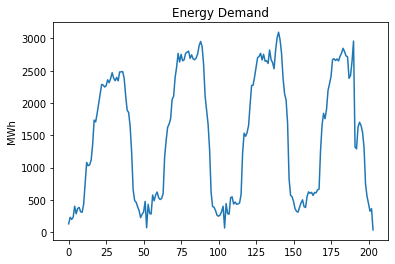

In [109]:
import matplotlib.pyplot as plt
import seaborn as sns
cleanduplicates['bookingID'].plot(title="Energy Demand")
plt.ylabel("MWh")
plt.show()

In [110]:
train['week_x'] = train['New_week'].astype(str)
dummies=['week_x']
dumies=pd.get_dummies(train[dummies], drop_first=True)
dumies.shape
dumies.head()

,week_x_10,week_x_11,week_x_12,week_x_13,week_x_14,week_x_15,week_x_16,week_x_17,week_x_18,week_x_19,week_x_2,week_x_20,week_x_21,week_x_22,week_x_23,week_x_24,week_x_25,week_x_26,week_x_27,week_x_28,week_x_29,week_x_3,week_x_30,week_x_31,week_x_32,week_x_33,week_x_34,week_x_35,week_x_36,week_x_37,week_x_38,week_x_39,week_x_4,week_x_40,week_x_41,week_x_42,week_x_43,week_x_44,week_x_45,week_x_46,week_x_47,week_x_48,week_x_49,week_x_5,week_x_50,week_x_51,week_x_52,week_x_6,week_x_7,week_x_8,week_x_9
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [122]:
df_train=pd.concat([train, dumies],axis=1)
df_train.head()

,year,New_week,bookingID,week_x,week_x_10,week_x_11,week_x_12,week_x_13,week_x_14,week_x_15,week_x_16,week_x_17,week_x_18,week_x_19,week_x_2,week_x_20,week_x_21,week_x_22,week_x_23,week_x_24,week_x_25,week_x_26,week_x_27,week_x_28,week_x_29,week_x_3,week_x_30,week_x_31,week_x_32,week_x_33,week_x_34,week_x_35,week_x_36,week_x_37,week_x_38,week_x_39,week_x_4,week_x_40,week_x_41,week_x_42,week_x_43,week_x_44,week_x_45,week_x_46,week_x_47,week_x_48,week_x_49,week_x_5,week_x_50,week_x_51,week_x_52,week_x_6,week_x_7,week_x_8,week_x_9
0,2016,1,128,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2016,2,229,2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2016,3,197,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2016,4,229,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2016,5,401,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [127]:
X_train = df_train[ (df_train.year < 2018)]
y_train = df_train[ (df_train.year < 2018)]

X_test = df_train[ (df_train.year >= 2018)]
y_test = df_train[ (df_train.year >=2018)]
X_test.head()

,year,New_week,bookingID,week_x,week_x_10,week_x_11,week_x_12,week_x_13,week_x_14,week_x_15,week_x_16,week_x_17,week_x_18,week_x_19,week_x_2,week_x_20,week_x_21,week_x_22,week_x_23,week_x_24,week_x_25,week_x_26,week_x_27,week_x_28,week_x_29,week_x_3,week_x_30,week_x_31,week_x_32,week_x_33,week_x_34,week_x_35,week_x_36,week_x_37,week_x_38,week_x_39,week_x_4,week_x_40,week_x_41,week_x_42,week_x_43,week_x_44,week_x_45,week_x_46,week_x_47,week_x_48,week_x_49,week_x_5,week_x_50,week_x_51,week_x_52,week_x_6,week_x_7,week_x_8,week_x_9
104,2018,1,64,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
105,2018,2,442,2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
106,2018,3,287,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
107,2018,4,278,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
108,2018,5,532,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [0]:
X_train=X_train.drop(['bookingID','year','New_week','week_x'],axis=1)
keep=['bookingID']
y_train=y_train[keep]

X_test=X_test.drop(['bookingID','year','New_week','week_x'],axis=1)
keep=['bookingID']
y_test=y_test[keep]

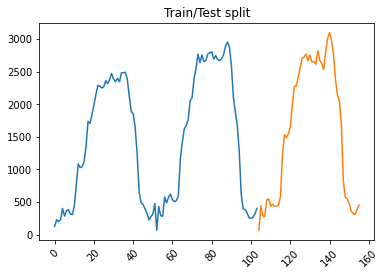

In [130]:
plt.plot(y_train.index, y_train.bookingID.values, label="train")
plt.plot(y_test.index, y_test.bookingID.values, label="test")
plt.title("Train/Test split")
plt.xticks(rotation=45)
plt.show()

In [0]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
reg = LinearRegression().fit(X_train, y_train)
p_train = reg.predict(X_train)
p_test = reg.predict(X_test)

In [0]:
RMSE_train = np.sqrt(mean_squared_error(y_train, p_train))
RMSE_test = np.sqrt(mean_squared_error(y_test, p_test))

In [133]:
RMSE_train

160.2612350555756

In [134]:
RMSE_test

197.74806718884307

In [0]:
X_test['p_test']=p_test
X_test['y_test']=y_test

In [0]:
X_test['e'] =X_test['y_test'] - X_test['p_test']

rmse = np.sqrt(np.mean(X_test['e']**2)).round(2)
mape = np.round(np.mean(np.abs(100*X_test['e']/X_test['y_test'])), 0)


In [137]:
print('RMSE = $', rmse)
print('MAPE =', mape, '%')

RMSE = $ 197.75
MAPE = 12.0 %


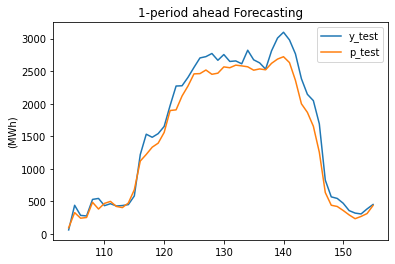

In [138]:
X_test[["y_test", "p_test"]].plot()

plt.title("1-period ahead Forecasting")
plt.ylabel("(MWh)")
plt.legend()
plt.show()

In [0]:
import matplotlib.pyplot as plt

In [0]:
X_test[["y_test"]].plot()

plt.title("1-period ahead Forecasting")
plt.ylabel("(MWh)")
plt.legend()
plt.show()

In [0]:
import matplotlib.pyplot as plt
sns.boxplot(data=cleanduplicates, x="day", y="bookingID")
plt.title("Seasonality analysis: Distribution over weekdays")
plt.ylabel("(Qtd Booking)")
plt.show()

In [0]:
sns.boxplot(data=cleanduplicates, x="month", y="bookingID")
plt.title("Seasonality analysis: Distribution over weekdays")
plt.ylabel("(Qtd Booking)")
plt.show()

In [0]:
manifesto.groupby(['week'])['week'].count()

In [0]:
manifesto.groupby(['month'])['month'].count()

In [0]:
dummies=['month_x','day_x']
dummies=pd.get_dummies(cleanduplicates[dummies], drop_first=True)
dummies.shape
dummies.head()

In [0]:
cleanduplicates_copia=cleanduplicates.copy()

In [0]:
cleanduplicates.head(1)

In [0]:
cleanduplicates=cleanduplicates.drop(['month_x','day_x','week','day','month'],axis=1)
df=pd.concat([cleanduplicates, dummies],axis=1)
df.head()

In [0]:
df=pd.concat([cleanduplicates, dummies],axis=1)
df.head()

### Data Understanding 

### Data Preprocessing 

### Data Exploration 

#### Adults per bookings

<img src="adultsm.JPG" alt="xxx" style="width: 600px;"/>

#### Children per bookings

<img src="childrenm.JPG" alt="xxx" style="width: 600px;"/>

#### Babies per bookings

<img src="babiesm.JPG" alt="xxx" style="width: 600px;"/>

#### Pickup Local per bookings

<img src="pickuplocalm.JPG" alt="xxx" style="width: 600px;"/>

#### Dropoff Local per bookings

<img src="dropofflocalm.JPG" alt="xxx" style="width: 600px;"/>

#### Flight number per bookings

<img src="flightnm.JPG" alt="xxx" style="width: 600px;"/>

#### Payment Type per bookings

<img src="paymentTypem.JPG" alt="xxx" style="width: 600px;"/>

#### Type of Service per bookings

<img src="typeOfServicem.JPG" alt="xxx" style="width: 600px;"/>

#### Type of transfer per bookings

<img src="typeOfTrasnferm.JPG" alt="xxx" style="width: 600px;"/>

#### Service Status per bookings

<img src="serviceStatusm.JPG" alt="xxx" style="width: 600px;"/>

#### Booking Status per bookings

<img src="bookingStatusm.JPG" alt="xxx" style="width: 600px;"/>